# MaxVQA Video Stutter Detection Model

## Setup

In [31]:
import yaml
import math
import torch
import decord
import open_clip
import numpy as np
from time import time
from tqdm import tqdm
from itertools import cycle
from decord import VideoReader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from DOVER.dover import DOVER
from DOVER.dover.datasets import spatial_temporal_view_decomposition, UnifiedFrameSampler
from model import TextEncoder, MaxVQA, EnhancedVisualEncoder

In [32]:
dimension_names = [
    "overall quality score",
    "contents", "composition", "color", "lighting", "camera (temporal) trajectory",
    "aesthetic perspective",
    "sharpness", "focus", "noise", "motion blur", "flicker", "exposure", "compression artefacts", "motion (frame) fluency",
    "technical perspective",
]

positive_descs = [
    "high quality",
    "good content", "organized composition", "vibrant color", "contrastive lighting", "consistent trajectory",
    "good aesthetics",
    "sharp", "in-focus", "noiseless", "clear-motion", "stable", "well-exposed", "original", "fluent",
    "clear",
]

negative_descs = [
    "low quality",
    "bad content", "chaotic composition", "faded color", "gloomy lighting", "incoherent trajectory",
    "bad aesthetics",
    "fuzzy", "out-of-focus", "noisy", "blurry-motion", "shaky", "poorly-exposed", "compressed", "choppy",
    "severely degraded",
]

context = "X"
pos_prompts = [ f"a {context} {desc} photo" for desc in positive_descs]
neg_prompts = [ f"a {context} {desc} photo" for desc in negative_descs]

In [33]:
def encode_text_prompts(prompts, tokenizer, model, device='cpu'):
    text_tokens = tokenizer(prompts).to(device)
    with torch.no_grad():
        embedding = model.token_embedding(text_tokens)
        text_features = model.encode_text(text_tokens).float()
    return text_tokens, embedding, text_features


def setup_models(text_prompts, opt, aesthetic_clip_len, technical_num_clips, device='cpu', use_aesthetic_features=False):
    # Initialize fast-vqa encoder
    fast_vqa_encoder = DOVER(**opt["model"]["args"]).to(device)
    fast_vqa_encoder.load_state_dict(torch.load("DOVER/pretrained_weights/DOVER.pth", map_location=device), strict=False)

    # Initialize CLIP model
    print(f"Chosen CLIP model: {'OpenAI RN50'}")
    # print(f"Available CLIP models: {open_clip.list_pretrained()}")
    clip_model, _, _ = open_clip.create_model_and_transforms("RN50", pretrained="openai")
    clip_model = clip_model.to(device)

    # Encode initialized text prompts
    tokenizer = open_clip.get_tokenizer("RN50")
    text_tokens, embedding, text_feats = encode_text_prompts(text_prompts, tokenizer, clip_model, device=device)
    text_encoder = TextEncoder(clip_model)

    # Visual encoder
    technical_clip_len = opt["inference"]["args"]["sample_types"]["technical"]["clip_len"]
    visual_encoder = EnhancedVisualEncoder(clip_model, fast_vqa_encoder, aesthetic_clip_len, technical_clip_len, technical_num_clips)

    # Initialise data samplers
    frame_interval = opt["inference"]["args"]["sample_types"]["technical"]["frame_interval"]

    temporal_samplers = {
        "technical": UnifiedFrameSampler(
            technical_clip_len,
            technical_num_clips,
            frame_interval
        )
    }

    # Generate MaxVQA model
    maxvqa = MaxVQA(text_tokens, embedding, text_encoder, share_ctx=True, device=device)

    state_dict = torch.load("maxvqa_maxwell.pt", map_location=device)
    maxvqa.load_state_dict(state_dict)
    maxvqa.initialize_inference(text_encoder)

    return text_encoder, visual_encoder, temporal_samplers, maxvqa


def extract_video_features(video, encoder, opt, temporal_samplers, use_aesthetic_features=False, device='cpu'):
    # Video preprocessing module
    mean = torch.FloatTensor([123.675, 116.28, 103.53]).reshape(-1,1,1,1)
    std = torch.FloatTensor([58.395, 57.12, 57.375]).reshape(-1,1,1,1)

    sample_feature_type = {"technical": opt["inference"]["args"]["sample_types"]["technical"]}
    video_data, frame_idx = spatial_temporal_view_decomposition(video, sample_feature_type, temporal_samplers)

    # Assuming that video_data is the preprocessed video from above step
    if use_aesthetic_features:
        frame_idx["aesthetic"] = frame_idx["technical"][0::2]
        data = {
            "technical": (video_data["technical"] - mean ) / std,
            "aesthetic": (video_data["technical"][:, 0::2] - mean ) / std
        }
        vis_feats = encoder(data["technical"].to(device), data["aesthetic"].to(device))
        # print(f' * Video data, aesthetic (tech / 2): {data["aesthetic"].shape}')
    else:
        data = {"technical": (video_data["technical"] - mean ) / std}
        vis_feats = encoder(data["technical"].to(device))

    # print(f' * Video data, technical: {data["technical"].shape}')
    # print(f'4) Concatenated CLIP + FAST features: {vis_feats.shape}')

    return vis_feats, frame_idx["technical"][0::2]


def rescale_score(raw_score, dim=-1):
    dim_means = [
        0.64816874, 0.7389499, 0.72287375, 0.7463802 , 0.8296112 ,
        0.7190873 , 0.6247339 , 0.54232854, 0.629289  , 0.5732389 ,
        0.69551915, 0.49694163, 0.68725526, 0.60615003, 0.88730884,
        0.5536831
    ]

    dim_stds = [
        0.16527903, 0.1164713 , 0.12123751, 0.13628706, 0.12584831,
        0.11652958, 0.15417372, 0.18802027, 0.16696042, 0.15306316,
        0.153056  , 0.1480174 , 0.1273537 , 0.16313092, 0.07106569,
        0.1876018
    ]

    x = (raw_score - dim_means[dim]) / dim_stds[dim]
    x = 1 / (1 + np.exp(-x))

    return x

### Visualising the results

In [34]:
def maxvqa_output_formatting(output):
    output_ = "\nResults: \n"

    for idx, (name, pos, neg, score) in enumerate(zip(dimension_names[7:], positive_descs[7:], negative_descs[7:], output[7:])):
        output_ += f"    * Metric #{idx}: \n"
        output_ += f"        * Metric name:  {name} \n"
        output_ += f"        * Score range:  ({neg}) => ({pos}) \n"
        output_ += f"        * Prediction:   {rescale_score(score, idx) * 100:.2f}% ({score:.4f}) \n"

    return output_

In [35]:
def plot(values, timestamps, video_name, true_values):
    priority_metrics = [7, 9, 11, 13, 14]
    plot_values = values[priority_metrics]
    titles = {
        "A": "Sharpness",
        "B": "Noise",
        "C": "Flicker",
        "D": "Compression artefacts",
        "E": "Motion fluency"
    }

    cycol = cycle(mcolors.TABLEAU_COLORS)
    fig, axes = plt.subplot_mosaic("AB;CD;EE", sharex=True, sharey=True, figsize=(12, 9), tight_layout=True)

    for value_id, (ax_id, title) in enumerate(titles.items()):
        mean_over_video = plot_values[value_id].mean()
        std_over_video = plot_values[value_id].std()

        axes[ax_id].set_title(title)
        axes[ax_id].grid(linewidth=0.2)

        if video_name in true_values.keys():
            for start, end in true_values[video_name]:
                axes[ax_id].axvspan(start, end, alpha=0.2, color='grey')

        axes[ax_id].axhline(mean_over_video, color='black', ls='--', linewidth=0.5)
        axes[ax_id].axhline(mean_over_video - 2 * std_over_video, color='black', ls='--', linewidth=0.5)
        axes[ax_id].plot(timestamps, plot_values[value_id], linewidth=1, color=next(cycol))

    fig.suptitle(f'MaxVQA Distortion of Video Artefacts ({video_name})', fontsize=16)
    fig.supylabel('Absolute score (0-1, bad-good)')
    fig.supxlabel('Video time (s)')
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.xticks(np.arange(math.floor(timestamps[0]), math.ceil(timestamps[-1]) + 1, math.ceil(timestamps[-1] / 20)))

    for ax in fig.get_axes():
        ax.label_outer()

    plt.show()

## Detection Inference

### Parameters & Setup

In [36]:
# video_path = '../../datasets/football-30s.mp4'
# video_path = '../../datasets/green-planet-30s.mp4'
# video_path = '../../datasets/rugby-1m.mp4'

video_path = '../../datasets/football-30s-stutter.mp4'
# video_path = '../../datasets/football-firing-football.mp4'
# video_path = '../../datasets/wild-dogs-stutter.mp4'
# video_path = '../../datasets/maxwell-stutter/firing-range.mp4'
# video_path = '../../datasets/maxwell-stutter/singer.mp4'
# video_path = '../../datasets/maxwell-stutter/chef-singer-chef.mp4'

# video_path = '../../datasets/useful-bbc-clips/BBCTVC_SKYW-14_1.mov'
# video_path = '../../datasets/useful-bbc-clips/BBCTVC_SKYW-14_2.mov'
# video_path = '../../datasets/useful-bbc-clips/BBCTVC_TPV-227_1.mov'
# video_path = '../../datasets/useful-bbc-clips/BBCTVCHIL-4_1.mp4'
# video_path = '../../datasets/useful-bbc-clips/BBCTVC_SON-189.mov'

frames = 256
device = 'cpu'

In [37]:
true_timesteps = {
    "football-30s-stutter": [(8, 10), (20, 21), (28, 29)],
    "football-firing-football": [(11, 18)],
    "chef-singer-chef": [(11, 17)],
    "wild-dogs-stutter": [(68, 69), (85, 87), (129, 131), (158, 159), (163, 165), (204, 206)],
    "BBCTVC_SKYW-14_1": [(6, 8)],
    "BBCTVC_SKYW-14_2": [(15, 17), (20, 22)],
    "BBCTVC_TPV-227_1": [(3, 4)],
    "BBCTVCHIL-4_1": [(25, 27)],
    "BBCTVC_SON-189": [(22, 23), ]
}

In [38]:
device = torch.device(device)
decord.bridge.set_bridge("torch")

In [39]:
# Get video length
vreader = VideoReader(video_path)
video_length_frames = len(vreader)
fps = vreader.get_avg_fps()
video_length_seconds = video_length_frames / fps

print("Path:", video_path)
print(f"Video length: {video_length_seconds:.2f}s, {video_length_frames} frames")

with open("maxvqa.yml", "r") as f:
    opt = yaml.safe_load(f)

# Load model
aesthetic_clip_len = frames  # length of single fragment for aesthetic analysis
technical_num_clips = 2 * (frames // 32)  # no. frame fragments for techical analysis (each len 32)

pos_neg_prompts = pos_prompts + neg_prompts

text_encoder, visual_encoder, temporal_samplers, maxvqa = setup_models(
    pos_neg_prompts,
    opt,
    aesthetic_clip_len,
    technical_num_clips,
    device=device
)

Path: ../../datasets/football-30s-stutter.mp4
Video length: 30.70s, 921 frames
divided
None False
Setting backbone: technical_backbone
Setting head: technical_head
Chosen CLIP model: OpenAI RN50


### Feature Extraction

In [40]:
# Extract features from test video
print("Extracting visual features from video...")
combined_outputs = []
start = time()

vis_feats, sampled_frames = extract_video_features(video_path, visual_encoder, opt, temporal_samplers)

time_features = time() - start

Extracting visual features from video...


### VQA Metric Prediction

In [41]:
# Run test video features through detection model
start = time()

print("Processing video with MaxVQA model...")
with torch.no_grad():
    raw_outputs = maxvqa(vis_feats, text_encoder, train=False, local=True)

combined_outputs.append(raw_outputs)
# print(f"10) Final predictions: {np.array(raw_outputs).shape}")

time_predictions = time() - start

Processing video with MaxVQA model...


In [42]:
print(f" * Timing results:")
print(f"     * Input video length : {video_length_seconds:.2f}s")
print(f"     * Feature extraction : {time_features:.2f}s")
print(f"     * Model prediction   : {time_predictions:.2f}s")
print(f"     * Combined total     : {time_features+time_predictions:.2f}s")

 * Timing results:
     * Input video length : 30.70s
     * Feature extraction : 134.84s
     * Model prediction   : 0.13s
     * Combined total     : 134.97s


### Visualise results

In [43]:
# Determine test frames sampled
video_id = video_path.split('/')[-1].split('.')[0]
sampled_timestamps = list(map(lambda i: round(i / fps, 2), sampled_frames))
local_scores = np.mean(combined_outputs, axis=0)

print(f"Original frame length: {video_length_frames}")
print(f"Local scores: {local_scores.shape}")
print(f"Sampled times: {np.array(sampled_frames).shape} ({sampled_frames[0]}, {sampled_timestamps[0]}) => ({sampled_frames[-1]}, {sampled_timestamps[-1]})")

Original frame length: 921
Local scores: (16, 256)
Sampled times: (256,) (0, 0.0) => (915, 30.5)


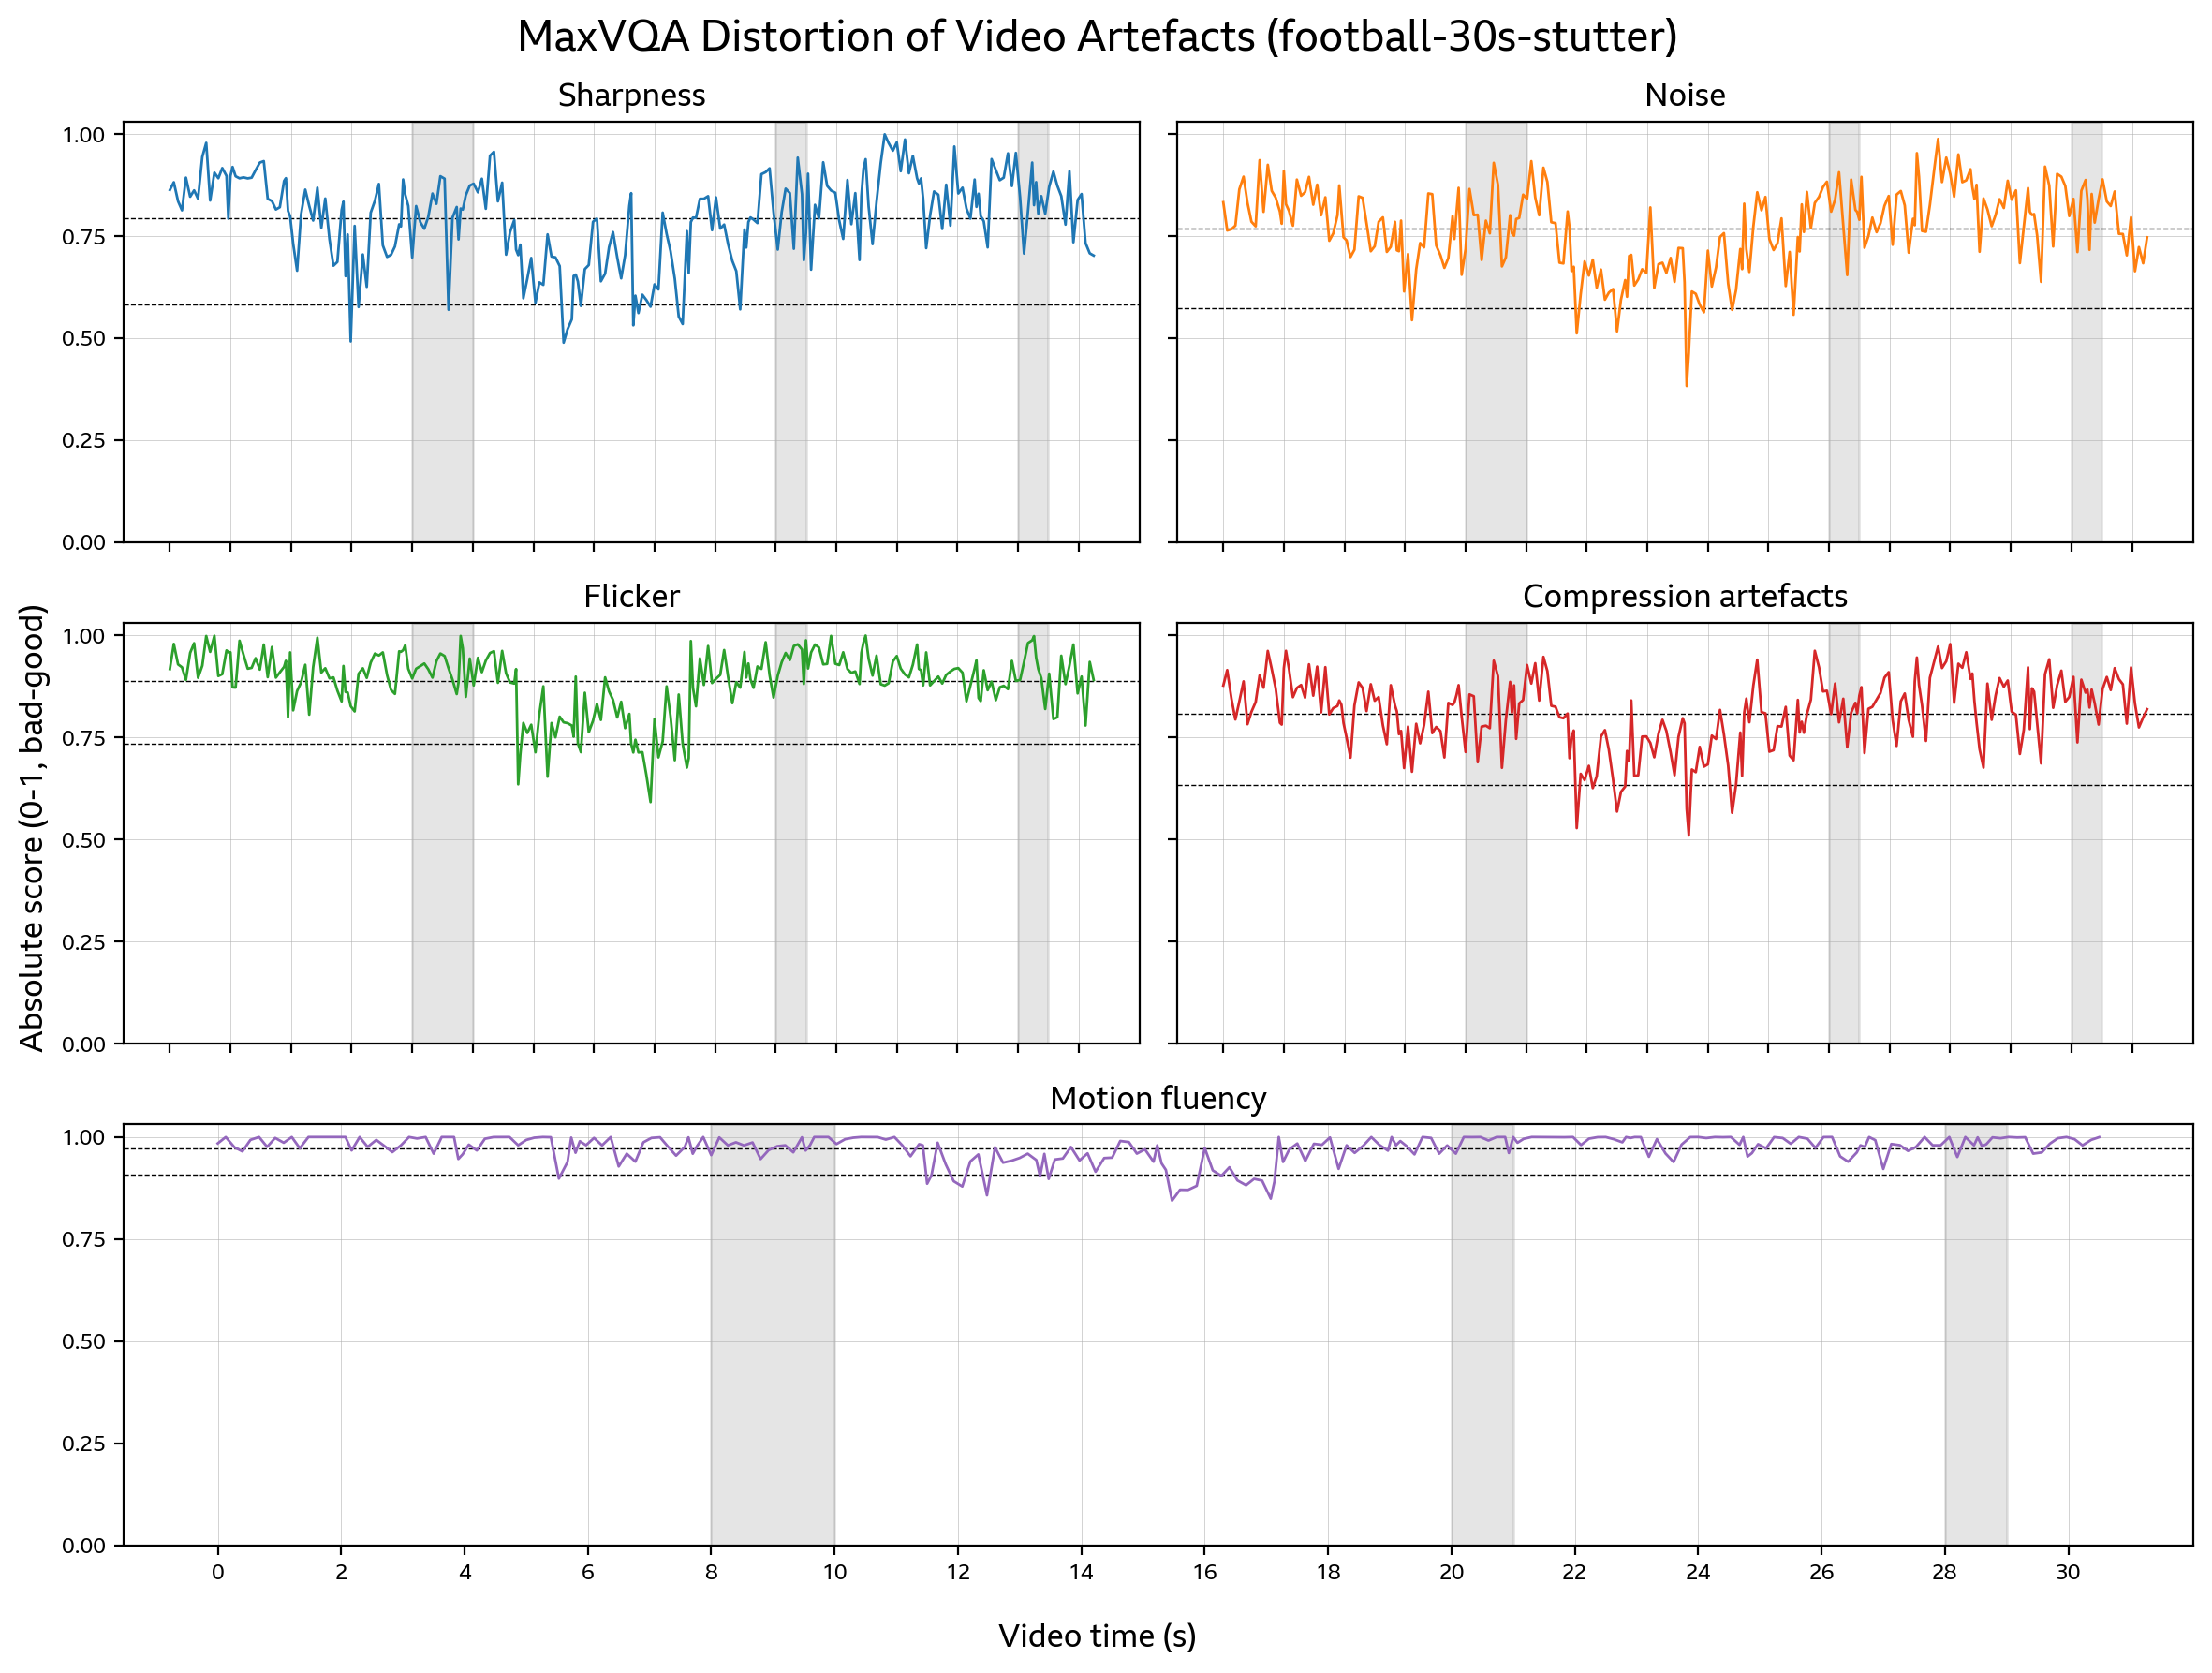

In [44]:
plot(local_scores, sampled_timestamps, video_id, true_timesteps)

In [45]:
global_scores = np.mean(local_scores, axis=1)
formatted_output = maxvqa_output_formatting(global_scores)
print(formatted_output)


Results: 
    * Metric #0: 
        * Metric name:  sharpness 
        * Score range:  (fuzzy) => (sharp) 
        * Prediction:   70.76% (0.7942) 
    * Metric #1: 
        * Metric name:  focus 
        * Score range:  (out-of-focus) => (in-focus) 
        * Prediction:   63.50% (0.8034) 
    * Metric #2: 
        * Metric name:  noise 
        * Score range:  (noisy) => (noiseless) 
        * Prediction:   59.46% (0.7693) 
    * Metric #3: 
        * Metric name:  motion blur 
        * Score range:  (blurry-motion) => (clear-motion) 
        * Prediction:   25.36% (0.5993) 
    * Metric #4: 
        * Metric name:  flicker 
        * Score range:  (shaky) => (stable) 
        * Prediction:   61.33% (0.8876) 
    * Metric #5: 
        * Metric name:  exposure 
        * Score range:  (poorly-exposed) => (well-exposed) 
        * Prediction:   81.33% (0.8906) 
    * Metric #6: 
        * Metric name:  compression artefacts 
        * Score range:  (compressed) => (original) 
       